# **Mask R-CNN model**

Install libraries

In [ ]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-m7j1shn9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-m7j1shn9
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5

Import libraries for Mask R-CNN

In [ ]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)


from matplotlib import pyplot as plt
from PIL import Image

Import dataset from Roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="hrBUUZBmlpIg1PWziWzX")
project = rf.workspace("segmentation-etub2").project("final-fire-dataset")
version = project.version(2)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...


Register datasets for training

In [ ]:
for d in ["fire_poly_train", "fire_poly_valid", "fire_poly_test"]:
    if d in DatasetCatalog.list():
        DatasetCatalog.remove(d)
    if d in MetadataCatalog.list():
         MetadataCatalog.remove(d)

VERSION = version.version

DATASET_BASE_PATH = f"/content/final-fire-dataset-{VERSION}"

# Now register the datasets
register_coco_instances("fire_poly_train", {}, f"{DATASET_BASE_PATH}/train/_annotations.coco.json", f"{DATASET_BASE_PATH}/train/")
register_coco_instances("fire_poly_valid", {}, f"{DATASET_BASE_PATH}/valid/_annotations.coco.json", f"{DATASET_BASE_PATH}/valid/")
register_coco_instances("fire_poly_test", {}, f"{DATASET_BASE_PATH}/test/_annotations.coco.json", f"{DATASET_BASE_PATH}/test/")

Load an image from the dataset

WARNING [05/17 19:27:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/17 19:27:30 d2.data.datasets.coco]: Loaded 2509 images in COCO format from /content/final-fire-dataset-2/train/_annotations.coco.json


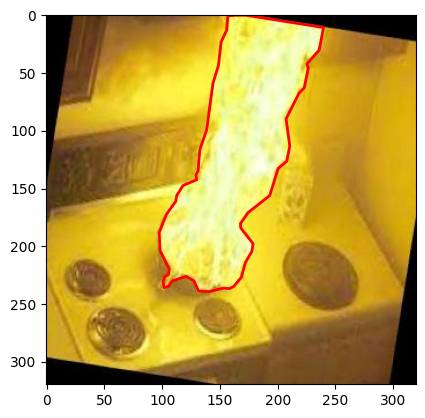

In [ ]:
dataset_train = DatasetCatalog.get("fire_poly_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

Train the Mask R-CNN model

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fire_poly_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("fire_poly_test",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 27 # 26 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Evaluation metrics and test results

In [ ]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    # Explicitly save the final model when early stopping occurs
                    checkpointer.save("model_final")
                    break

# Ensure the final model is saved even if max_iter is reached without early stopping
checkpointer.save("model_final")

do_test(cfg, model)

[05/17 19:27:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 115MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [05/17 19:27:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/17 19:27:45 d2.data.datasets.coco]: Loaded 2509 images in COCO format from /content/final-fire-dataset-2/train/_annotations.coco.json
[05/17 19:27:45 d2.data.build]: Removed 6 images with no usable annotations. 2503 images left.
[05/17 19:27:45 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| segmentatio.. | 0            |  Class A   | 840          |  Class B   | 784          |
|    Class C    | 894          |  Class D   | 606          |  Class F   | 465          |
|               |              |            |              |            |              |
|     total     | 3589         |            |              |            |              |
[05/17 19:27:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


[05/17 19:27:55 d2.utils.events]:  iter: 19  total_loss: 3.998  loss_cls: 3.133  loss_box_reg: 0.1127  loss_mask: 0.6929  loss_rpn_cls: 0.02535  loss_rpn_loc: 0.008329     lr: 4.9953e-06  max_mem: 1771M
[05/17 19:28:06 d2.utils.events]:  eta: 1:30:25  iter: 39  total_loss: 3.793  loss_cls: 2.955  loss_box_reg: 0.1202  loss_mask: 0.6925  loss_rpn_cls: 0.0177  loss_rpn_loc: 0.009059     lr: 9.9902e-06  max_mem: 1772M
[05/17 19:28:12 d2.utils.events]:  eta: 0:54:49  iter: 59  total_loss: 3.288  loss_cls: 2.453  loss_box_reg: 0.1178  loss_mask: 0.6916  loss_rpn_cls: 0.02004  loss_rpn_loc: 0.009151     lr: 1.4985e-05  max_mem: 1774M
[05/17 19:28:19 d2.utils.events]:  eta: 0:54:59  iter: 79  total_loss: 2.651  loss_cls: 1.746  loss_box_reg: 0.1267  loss_mask: 0.6883  loss_rpn_cls: 0.04708  loss_rpn_loc: 0.01282     lr: 1.998e-05  max_mem: 1774M
[05/17 19:28:26 d2.utils.events]:  eta: 0:56:10  iter: 99  total_loss: 1.656  loss_cls: 0.7939  loss_box_reg: 0.1153  loss_mask: 0.6885  loss_rpn_cls

OrderedDict([('bbox',
              {'AP': 24.678696697025636,
               'AP50': 42.1788738127755,
               'AP75': 25.253437589664358,
               'APs': 14.955613460162597,
               'APm': 16.836118492748973,
               'APl': 31.891463446997925,
               'AP-segmentation-masks': nan,
               'AP-Class A': 16.518714708565085,
               'AP-Class B': 31.67060468982767,
               'AP-Class C': 17.005062607909206,
               'AP-Class D': 22.742685697809282,
               'AP-Class F': 35.45641578101693}),
             ('segm',
              {'AP': 23.7550809310912,
               'AP50': 41.13460255058245,
               'AP75': 24.025003593974024,
               'APs': 10.813903767470576,
               'APm': 11.150648924013314,
               'APl': 33.53027171453356,
               'AP-segmentation-masks': nan,
               'AP-Class A': 14.228752342971907,
               'AP-Class B': 33.07899576126267,
               'AP-Class

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("fire_poly_valid")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im

[05/17 19:43:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [05/17 19:43:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/17 19:43:25 d2.data.datasets.coco]: Loaded 717 images in COCO format from /content/final-fire-dataset-2/valid/_annotations.coco.json


Visualize an image

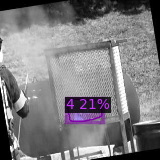

In [ ]:
im

Save best Mask R-CNN model

In [ ]:
from google.colab import files
files.download(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>